# **Classificando Operações de Crédito de empresas brasileiras com inteligência artificial**

# **1. Entendimento dos dados¶**

## **1.1 Coleta dos dados**

🔳 **Configurando o ambiente e carregando os dados**

In [ ]:
# 1️⃣ Instalar Java 8 (necessário para o Spark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# 2️⃣ Baixar e configurar o Spark
# Baixar o Spark 3.2.1 com Hadoop 2.7
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

# Extrair o arquivo baixado
!tar xf spark-3.2.1-bin-hadoop2.7.tgz

# Configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

# 3️⃣ Instalar o findspark e inicializar o Spark
!pip install -q findspark
import findspark
findspark.init()

# 4️⃣ Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 5️⃣ Criar uma sessão Spark
from pyspark.sql import SparkSession

# Criar a sessão Spark
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("ParquetProcessing") \
    .getOrCreate()

# 6️⃣ Carregar o arquivo Parquet
try:
    df_spark = spark.read.parquet("/content/drive/My Drive/BCB_Dados_Corrigidos_2024/dados_consolidados.parquet")
    print("Arquivo Parquet carregado com sucesso!")
    df_spark.show(20, truncate=False)  # Mostrar as primeiras 20 linhas
except Exception as e:
    print("Erro ao carregar o arquivo Parquet:", e)

Mounted at /content/drive
Erro ao carregar o arquivo Parquet: Path does not exist: file:/content/drive/My Drive/BCB_Dados_Corrigidos_2024/dados_consolidados.parquet


In [ ]:
# Liste os arquivos no diretório para confirmar o caminho
!ls "/content/drive/My Drive/"
!ls "/content/drive/My Drive/BCB_Dados_Corrigidos_2024/"

 Avaliação.gdoc		    'Colab Notebooks'  'Projetos Ciência de dados'
 BCB_Dados_Corrigidos_2024   GitHub	        Spacy.ipynb
dados_teste.parquet  dados_treino.parquet  modelo_rf


🔳 **Ordenando a base de dados pela data**

In [ ]:
from pyspark.sql.functions import col

dados_ordenados = df_spark.orderBy(col("data_base").asc())

# Mostrar as primeiras 10 linhas ordenadas
dados_ordenados.show(20, truncate=False)

+----------+---+--------+----+-------+---------------------------+----------+--------------+---------------------------------------------+----------------------------------------+-------------------------+------------------+-------------------+--------------------+---------------------------+-----------------------------+------------------------------+------------------------------+---------------------------+------------------------+--------------+------------------------------+------------------+
|data_base |uf |tcb     |sr  |cliente|ocupacao                   |cnae_secao|cnae_subclasse|porte                                        |modalidade                              |origem                   |indexador         |numero_de_operacoes|a_vencer_ate_90_dias|a_vencer_de_91_ate_360_dias|a_vencer_de_361_ate_1080_dias|a_vencer_de_1081_ate_1800_dias|a_vencer_de_1801_ate_5400_dias|a_vencer_acima_de_5400_dias|vencido_acima_de_15_dias|carteira_ativa|carteira_inadimplida_arrastada|ativo_proble

🔳 **Criando uma cópia da base de dados que contém os dados odenados pela data**

In [ ]:
dados_copia = dados_ordenados.select("*")
dados_copia.show(20, truncate=False)


+----------+---+--------+----+-------+---------------------------+----------+--------------+---------------------------------------------+----------------------------------------+-------------------------+------------------+-------------------+--------------------+---------------------------+-----------------------------+------------------------------+------------------------------+---------------------------+------------------------+--------------+------------------------------+------------------+
|data_base |uf |tcb     |sr  |cliente|ocupacao                   |cnae_secao|cnae_subclasse|porte                                        |modalidade                              |origem                   |indexador         |numero_de_operacoes|a_vencer_ate_90_dias|a_vencer_de_91_ate_360_dias|a_vencer_de_361_ate_1080_dias|a_vencer_de_1081_ate_1800_dias|a_vencer_de_1801_ate_5400_dias|a_vencer_acima_de_5400_dias|vencido_acima_de_15_dias|carteira_ativa|carteira_inadimplida_arrastada|ativo_proble

## **1.2 Verificação da qualidade dos dados**

 🔳 **Verificando número de linhas e colunas**

In [ ]:
num_linhas = dados_copia.count()  # Contar número de linhas
num_colunas = len(dados_copia.columns)  # Contar número de colunas

print(f"Número total de linhas: {num_linhas}")
print(f"Número total de colunas: {num_colunas}")

Número total de linhas: 102264425
Número total de colunas: 23


🔳  **Verificando informações da base de dados**

In [ ]:
# Verifica o schema (tipos de dados e colunas)
print("=== Schema do DataFrame ===")
dados_copia.printSchema()

=== Schema do DataFrame ===
root
 |-- data_base: string (nullable = true)
 |-- uf: string (nullable = true)
 |-- tcb: string (nullable = true)
 |-- sr: string (nullable = true)
 |-- cliente: string (nullable = true)
 |-- ocupacao: string (nullable = true)
 |-- cnae_secao: string (nullable = true)
 |-- cnae_subclasse: string (nullable = true)
 |-- porte: string (nullable = true)
 |-- modalidade: string (nullable = true)
 |-- origem: string (nullable = true)
 |-- indexador: string (nullable = true)
 |-- numero_de_operacoes: string (nullable = true)
 |-- a_vencer_ate_90_dias: double (nullable = true)
 |-- a_vencer_de_91_ate_360_dias: double (nullable = true)
 |-- a_vencer_de_361_ate_1080_dias: double (nullable = true)
 |-- a_vencer_de_1081_ate_1800_dias: double (nullable = true)
 |-- a_vencer_de_1801_ate_5400_dias: double (nullable = true)
 |-- a_vencer_acima_de_5400_dias: double (nullable = true)
 |-- vencido_acima_de_15_dias: double (nullable = true)
 |-- carteira_ativa: double (nullabl

🔳 **Verificando a existência de valores inconsistentes**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnull

# Supondo que você já tenha uma sessão Spark ativa e o DataFrame dados_copia carregado

def verifica_valores_especiais(df):
    """
    Verifica colunas com valores NaN, traço ou em branco (diferentes tipos) em um DataFrame do PySpark.

    Args:
        df: O DataFrame do PySpark a ser analisado.

    Returns:
        Um dicionário contendo listas de colunas com cada tipo de valor especial.
    """

    # Verificando colunas com valores NaN
    colunas_com_nan = [coluna for coluna in df.columns if df.filter(col(coluna).isNull()).count() > 0]

    # Tipos de valores em branco ou inconsistentes
    tipos_de_branco = ['', ' ', '  ', '-', '...']  # Adicione outros se necessário

    # Verificando colunas com valores em branco ou inconsistentes
    colunas_com_branco = []
    colunas_com_traco = []

    for coluna in df.columns:
        # Verifica se há valores em branco ou inconsistentes
        for tipo in tipos_de_branco:
            if df.filter(col(coluna) == tipo).count() > 0:
                colunas_com_branco.append(coluna)
                break  # Evita adicionar a coluna várias vezes

        # Verifica se há traços
        if df.filter(col(coluna) == '-').count() > 0:
            colunas_com_traco.append(coluna)

    return {
        'nan': colunas_com_nan,
        'branco': colunas_com_branco,
        'traco': colunas_com_traco
    }

# Aplicando a função ao DataFrame dados_copia
resultados = verifica_valores_especiais(dados_copia)

print("Colunas com valores NaN:")
print(resultados['nan'])

print("\nColunas com valores em branco:")
print(resultados['branco'])

print("\nColunas com valores com traço:")
print(resultados['traco'])

# Opcional: Análise combinada
colunas_com_especiais = list(set(
    resultados['nan'] + resultados['branco'] + resultados['traco']
))

print("\nColunas com valores NaN, em branco OU com traço:")
print(colunas_com_especiais)

Colunas com valores NaN:
['sr']

Colunas com valores em branco:
['ocupacao', 'cnae_secao', 'cnae_subclasse']

Colunas com valores com traço:
['ocupacao', 'cnae_secao', 'cnae_subclasse']

Colunas com valores NaN, em branco OU com traço:
['cnae_subclasse', 'ocupacao', 'sr', 'cnae_secao']


*🔳* **Verificando a existência de valores nulos**

In [ ]:
from pyspark.sql.functions import col, sum, format_number

# 1. Contar nulos em todas as colunas
contagem_nulos = dados_copia.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in dados_copia.columns
])

# 2. Calcular porcentagens
total_linhas = dados_copia.count()
porcentagens_nulos = contagem_nulos.select([
    format_number((col(c) / total_linhas * 100), 6).alias(c)
    for c in dados_copia.columns
])

# 3. Exibir resultados
print("=== VALORES NULOS ===")
print("Contagem:")
contagem_nulos.show(truncate=False)

print("\nPorcentagem (%):")
porcentagens_nulos.show(truncate=False)

=== VALORES NULOS ===
Contagem:
+---------+---+---+--------+-------+--------+----------+--------------+-----+----------+------+---------+-------------------+--------------------+---------------------------+-----------------------------+------------------------------+------------------------------+---------------------------+------------------------+--------------+------------------------------+------------------+
|data_base|uf |tcb|sr      |cliente|ocupacao|cnae_secao|cnae_subclasse|porte|modalidade|origem|indexador|numero_de_operacoes|a_vencer_ate_90_dias|a_vencer_de_91_ate_360_dias|a_vencer_de_361_ate_1080_dias|a_vencer_de_1081_ate_1800_dias|a_vencer_de_1801_ate_5400_dias|a_vencer_acima_de_5400_dias|vencido_acima_de_15_dias|carteira_ativa|carteira_inadimplida_arrastada|ativo_problematico|
+---------+---+---+--------+-------+--------+----------+--------------+-----+----------+------+---------+-------------------+--------------------+---------------------------+------------------------

🔳 **Verificando quantidade de "-" (traços) em cada coluna**

In [ ]:
from pyspark.sql.functions import col, sum

# 1. Contar traços em todas as colunas
contagem_tracos = dados_copia.select([
    sum((col(c).cast("string") == "-").cast("int")).alias(c)
    for c in dados_copia.columns
])

# 2. Calcular porcentagens
total_linhas = dados_copia.count()
porcentagens = contagem_tracos.select([
    (col(c) / total_linhas * 100).alias(c)
    for c in dados_copia.columns
])

# 3. Exibir no formato desejado
print("Contagem de '-' por coluna:")
contagem_tracos.show(truncate=False)

print("\nPorcentagem do total (%):")
porcentagens.show(truncate=False)

Contagem de '-' por coluna:
+---------+---+---+---+-------+--------+----------+--------------+-----+----------+------+---------+-------------------+--------------------+---------------------------+-----------------------------+------------------------------+------------------------------+---------------------------+------------------------+--------------+------------------------------+------------------+
|data_base|uf |tcb|sr |cliente|ocupacao|cnae_secao|cnae_subclasse|porte|modalidade|origem|indexador|numero_de_operacoes|a_vencer_ate_90_dias|a_vencer_de_91_ate_360_dias|a_vencer_de_361_ate_1080_dias|a_vencer_de_1081_ate_1800_dias|a_vencer_de_1801_ate_5400_dias|a_vencer_acima_de_5400_dias|vencido_acima_de_15_dias|carteira_ativa|carteira_inadimplida_arrastada|ativo_problematico|
+---------+---+---+---+-------+--------+----------+--------------+-----+----------+------+---------+-------------------+--------------------+---------------------------+-----------------------------+-------------

🔳 **Verificando a existência de dados duplicados**

* Não há duplicados

🔳 **Criado a coluna classe em toda base de dados**

In [ ]:
from pyspark.sql.functions import col, when

# Criar a nova base 'dados_copia_1' com a coluna 'classe'
dados_copia_1 = dados_copia.withColumn(
    "classe",
    when(
        (col("ativo_problematico") / col("carteira_ativa") > 0.1) |
        (col("carteira_inadimplida_arrastada") / col("carteira_ativa") > 0.15),
        "Alto Risco"
    )
    .when(
        (col("vencido_acima_de_15_dias") / col("carteira_ativa") > 0.05) |
        (col("numero_de_operacoes") <= 15),
        "Médio Risco"
    )
    .otherwise("Baixo Risco")
)

# Visualizar as primeiras linhas da base transformada (com a nova coluna)
dados_copia_1.show(20,truncate=False)

+----------+---+--------+----+-------+---------------------------+----------+--------------+---------------------------------------------+----------------------------------------+-------------------------+------------------+-------------------+--------------------+---------------------------+-----------------------------+------------------------------+------------------------------+---------------------------+------------------------+--------------+------------------------------+------------------+-----------+
|data_base |uf |tcb     |sr  |cliente|ocupacao                   |cnae_secao|cnae_subclasse|porte                                        |modalidade                              |origem                   |indexador         |numero_de_operacoes|a_vencer_ate_90_dias|a_vencer_de_91_ate_360_dias|a_vencer_de_361_ate_1080_dias|a_vencer_de_1081_ate_1800_dias|a_vencer_de_1801_ate_5400_dias|a_vencer_acima_de_5400_dias|vencido_acima_de_15_dias|carteira_ativa|carteira_inadimplida_arrastada|

🔳 **Quantidades de cada classe na base de dados**

In [ ]:
# Registrar a tabela temporária
dados_copia_1.createOrReplaceTempView("dados_credito")

# Executar consulta SQL completa
query = """
WITH contagem_por_classe AS (
  SELECT
    classe,
    COUNT(*) as quantidade,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM dados_credito), 2) as porcentagem
  FROM dados_credito
  GROUP BY classe
)
SELECT * FROM contagem_por_classe
UNION ALL
SELECT
  'TOTAL' as classe,
  (SELECT COUNT(*) FROM dados_credito) as quantidade,
  100.00 as porcentagem
ORDER BY quantidade DESC
"""

resultado_final = spark.sql(query)
resultado_final.show()

+-----------+----------+-----------+
|     classe|quantidade|porcentagem|
+-----------+----------+-----------+
|      TOTAL| 102264425|     100.00|
|Baixo Risco|  70786076|      69.22|
| Alto Risco|  27035996|      26.44|
|Médio Risco|   4442353|       4.34|
+-----------+----------+-----------+



🔳 **Visualizando os tipos de ocupaçao e a quantidade de cada ocupação**

In [ ]:
# Consulta para ocupacao
ocupacao_distinct = spark.sql("""
WITH dados_validos AS (
  SELECT ocupacao
  FROM dados_credito
  WHERE ocupacao != '-' AND ocupacao IS NOT NULL
),
contagem AS (
  SELECT
    ocupacao AS tipo_ocupacao,
    COUNT(*) AS quantidade
  FROM dados_validos
  GROUP BY ocupacao
)
SELECT tipo_ocupacao, quantidade FROM contagem
UNION ALL
SELECT
  'TOTAL' AS tipo_ocupacao,
  (SELECT COUNT(*) FROM dados_validos) AS quantidade
ORDER BY
  CASE WHEN tipo_ocupacao = 'TOTAL' THEN 1 ELSE 0 END,
  quantidade DESC
""")

print("="*80)
print("Tipos de Ocupação e Quantidade de Cada")
print("="*80)
ocupacao_distinct.show(ocupacao_distinct.count(), truncate=False)

Tipos de Ocupação e Quantidade de Cada
+-----------------------------------------------+----------+
|tipo_ocupacao                                  |quantidade|
+-----------------------------------------------+----------+
|PF - Outros                                    |2492163   |
|PF - Empresário                                |2161788   |
|PF - Autônomo                                  |2047295   |
|PF - Empregado de empresa privada              |2042407   |
|PF - Servidor ou empregado público             |2040503   |
|PF - Aposentado/pensionista                    |1813045   |
|PF - MEI                                       |1057962   |
|PF - Empregado de entidades sem fins lucrativos|746891    |
|TOTAL                                          |14402054  |
+-----------------------------------------------+----------+



* Essa coluna que mostra os tipos de ocupação possui 102.264.425 linhas no total, sendo que dessas somente 14.402.054 são realmente valores reais e 87.862.371 são valores inválidos, com traço.

🔳 **Quantidades de cada classe na coluna ocupacao, considerando as linhas com valores reais excluindo as linhas com "-"(traço)**

In [ ]:
# Registrar a tabela temporária
dados_copia_1.createOrReplaceTempView("dados_credito")

# Consulta SQL filtrada
query_filtrada = """
WITH dados_filtrados AS (
  SELECT *
  FROM dados_credito
  WHERE ocupacao != '-' AND ocupacao IS NOT NULL
),
contagem_por_classe AS (
  SELECT
    classe,
    COUNT(*) as quantidade,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM dados_filtrados), 2) as porcentagem
  FROM dados_filtrados
  GROUP BY classe
)
SELECT * FROM contagem_por_classe
UNION ALL
SELECT
  'TOTAL' as classe,
  (SELECT COUNT(*) FROM dados_filtrados) as quantidade,
  100.00 as porcentagem
ORDER BY quantidade DESC
"""

resultado_filtrado = spark.sql(query_filtrada)
resultado_filtrado.show()

+-----------+----------+-----------+
|     classe|quantidade|porcentagem|
+-----------+----------+-----------+
|      TOTAL|  14402054|     100.00|
|Baixo Risco|   8088127|      56.16|
| Alto Risco|   5460860|      37.92|
|Médio Risco|    853067|       5.92|
+-----------+----------+-----------+



* A coluna ocupacao considerando somente valores reais possui 8.088.127 da classe baixo risco, enquanto o total dessa classe na base de dados completa é 70.786.076.

🔳 **Visualizando os tipos de atividade econômica e a quantidade de cada cnae_secao**

In [ ]:
# Consulta para cnae_secao
cnae_secao_distinct = spark.sql("""
WITH dados_validos AS (
  SELECT cnae_secao
  FROM dados_credito
  WHERE cnae_secao != '-' AND cnae_secao IS NOT NULL
),
contagem AS (
  SELECT
    cnae_secao AS grandes_setores,
    COUNT(*) AS quantidade
  FROM dados_validos
  GROUP BY cnae_secao
)
SELECT grandes_setores, quantidade FROM contagem
UNION ALL
SELECT
  'TOTAL' AS grandes_setores,
  (SELECT COUNT(*) FROM dados_validos) AS quantidade
ORDER BY
  CASE WHEN grandes_setores = 'TOTAL' THEN 1 ELSE 0 END,
  quantidade DESC
""")

print("\n" + "="*80)
print("Classificação atividades econômicas por grandes setores")
print("="*80)
cnae_secao_distinct.show(cnae_secao_distinct.count(), truncate=False)


Classificação atividades econômicas por grandes setores
+----------------------------------------------------------------------+----------+
|grandes_setores                                                       |quantidade|
+----------------------------------------------------------------------+----------+
|PJ - Comércio; reparação de veículos automotores e motocicletas       |29443971  |
|PJ - Indústrias de transformação                                      |19447344  |
|PJ - Atividades administrativas e serviços complementares             |5400597   |
|PJ - Construção                                                       |4698141   |
|PJ - Transporte, armazenagem e correio                                |4175655   |
|PJ - Atividades profissionais, científicas e técnicas                 |3757296   |
|PJ - Saúde humana e serviços sociais                                  |3464174   |
|PJ - Informação e comunicação                                         |2862165   |
|PJ - Alojamento e 

* Essa coluna que mostra as atividades econômicas por grande setor possui 102.264.425 linhas no total, sendo que dessas 87.862.371 são realmente nomes de setores e 14.402.054 são valores inválidos, com traço.

🔳 **Quantidades de cada classe na coluna cnae_secao, considerando as linhas com valores reais excluindo as linhas com "-"(traço)**

In [ ]:
# Análise para cnae_secao
query_cnae_secao = """
WITH dados_filtrados AS (
  SELECT *
  FROM dados_credito
  WHERE cnae_secao != '-' AND cnae_secao IS NOT NULL
),
contagem_por_classe AS (
  SELECT
    classe,
    COUNT(*) as quantidade,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM dados_filtrados), 2) as porcentagem
  FROM dados_filtrados
  GROUP BY classe
)
SELECT * FROM contagem_por_classe
UNION ALL
SELECT
  'TOTAL' as classe,
  (SELECT COUNT(*) FROM dados_filtrados) as quantidade,
  100.00 as porcentagem
ORDER BY quantidade DESC
"""

resultado_cnae_secao = spark.sql(query_cnae_secao)
print("Distribuição por classe (considerando apenas valores reais em cnae_secao):")
resultado_cnae_secao.show()

Distribuição por classe (considerando apenas valores reais em cnae_secao):
+-----------+----------+-----------+
|     classe|quantidade|porcentagem|
+-----------+----------+-----------+
|      TOTAL|  87862371|     100.00|
|Baixo Risco|  62697949|      71.36|
| Alto Risco|  21575136|      24.56|
|Médio Risco|   3589286|       4.09|
+-----------+----------+-----------+



🔳 **Visualizando os tipos de atividade econômica e a quantidade de cada cnae_subclasse**

In [ ]:
# Consulta para cnae_subclasse
cnae_subclasse_distinct = spark.sql("""
WITH dados_validos AS (
  SELECT cnae_subclasse
  FROM dados_credito
  WHERE cnae_subclasse != '-' AND cnae_subclasse IS NOT NULL
),
contagem AS (
  SELECT
    cnae_subclasse AS setor_especifico,
    COUNT(*) AS quantidade
  FROM dados_validos
  GROUP BY cnae_subclasse
)
SELECT setor_especifico, quantidade FROM contagem
UNION ALL
SELECT
  'TOTAL' AS setor_especifico,
  (SELECT COUNT(*) FROM dados_validos) AS quantidade
ORDER BY
  CASE WHEN setor_especifico = 'TOTAL' THEN 1 ELSE 0 END,
  quantidade DESC
""")

print("\n" + "="*80)
print("Atividade econômica por setor específico")
print("="*80)
cnae_subclasse_distinct.show(cnae_subclasse_distinct.count(), truncate=False)


Atividade econômica por setor específico
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|setor_especifico                                                                                                                                                                       |quantidade|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|PJ - Transporte rodoviário de carga, exceto produtos perigosos e mudanças, intermunicipal, interestadual e internacional                                                               |482702    |
|PJ - Construção de edifícios                                                                                                                                             

* Essa coluna que mostra as atividades econômicas por setor específico possui 102.264.425 linhas no total, sendo que dessas 84.886.262 são realmente nomes de setores e 17.428.163 são valores inválidos, com traço.

🔳 **Quantidades de cada classe na coluna cnae_subclasse, considerando as linhas com valores reais excluindo as linhas com "-"(traço)**

In [ ]:
# Análise para cnae_subclasse
query_cnae_subclasse = """
WITH dados_filtrados AS (
  SELECT *
  FROM dados_credito
  WHERE cnae_subclasse != '-' AND cnae_subclasse IS NOT NULL
),
contagem_por_classe AS (
  SELECT
    classe,
    COUNT(*) as quantidade,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM dados_filtrados), 2) as porcentagem
  FROM dados_filtrados
  GROUP BY classe
)
SELECT * FROM contagem_por_classe
UNION ALL
SELECT
  'TOTAL' as classe,
  (SELECT COUNT(*) FROM dados_filtrados) as quantidade,
  100.00 as porcentagem
ORDER BY quantidade DESC
"""

resultado_cnae_subclasse = spark.sql(query_cnae_subclasse)
print("\nDistribuição por classe (considerando apenas valores reais em cnae_subclasse):")
resultado_cnae_subclasse.show()


Distribuição por classe (considerando apenas valores reais em cnae_subclasse):
+-----------+----------+-----------+
|     classe|quantidade|porcentagem|
+-----------+----------+-----------+
|      TOTAL|  84836262|     100.00|
|Baixo Risco|  60575742|      71.40|
| Alto Risco|  20807422|      24.53|
|Médio Risco|   3453098|       4.07|
+-----------+----------+-----------+



🔳 **Visualizando as distribuições por segmento regulatório**

In [ ]:
# Consulta para a coluna sr (Segmento Regulatório)
sr_distinct = spark.sql("""
WITH dados_validos AS (
  SELECT sr
  FROM dados_credito
  WHERE sr IS NOT NULL
),
contagem AS (
  SELECT
    sr AS segmento_regulatorio,
    COUNT(*) AS quantidade
  FROM dados_validos
  GROUP BY sr
)
SELECT
  CASE
    WHEN segmento_regulatorio = 'S1' THEN 'S1 - Bancos grandes (porte >10% PIB ou ativos internacionais >US$ 10 bi)'
    WHEN segmento_regulatorio = 'S2' THEN 'S2 - Bancos médios (porte 1%-10% PIB)'
    WHEN segmento_regulatorio = 'S3' THEN 'S3 - Instituições pequenas (porte 0,1%-1% PIB)'
    WHEN segmento_regulatorio = 'S4' THEN 'S4 - Instituições muito pequenas (porte <0,1% PIB)'
    WHEN segmento_regulatorio = 'S5' THEN 'S5 - Instituições com metodologia simplificada'
    ELSE segmento_regulatorio
  END AS segmento_regulatorio,
  quantidade
FROM contagem
UNION ALL
SELECT
  'TOTAL GERAL' AS segmento_regulatorio,
  (SELECT COUNT(*) FROM dados_validos) AS quantidade
ORDER BY
  CASE WHEN segmento_regulatorio LIKE 'TOTAL%' THEN 1 ELSE 0 END,
  quantidade DESC
""")

print("="*100)
print("Distribuição por Segmento Regulatório (Resolução nº 4.553/2017)")
print("="*100)
print("Legenda completa:")
print("S1 - Bancos múltiplos/comerciais de grande porte (>10% PIB ou ativos >US$ 10 bi)")
print("S2 - Bancos médios (1%-10% PIB) e demais instituições relevantes")
print("S3 - Instituições pequenas (0,1%-1% PIB)")
print("S4 - Instituições muito pequenas (<0,1% PIB)")
print("S5 - Instituições com metodologia simplificada")
print("="*100)
sr_distinct.show(sr_distinct.count(), truncate=False)

Distribuição por Segmento Regulatório (Resolução nº 4.553/2017)
Legenda completa:
S1 - Bancos múltiplos/comerciais de grande porte (>10% PIB ou ativos >US$ 10 bi)
S2 - Bancos médios (1%-10% PIB) e demais instituições relevantes
S3 - Instituições pequenas (0,1%-1% PIB)
S4 - Instituições muito pequenas (<0,1% PIB)
S5 - Instituições com metodologia simplificada
+------------------------------------------------------------------------+----------+
|segmento_regulatorio                                                    |quantidade|
+------------------------------------------------------------------------+----------+
|S1 - Bancos grandes (porte >10% PIB ou ativos internacionais >US$ 10 bi)|27577152  |
|S4 - Instituições muito pequenas (porte <0,1% PIB)                      |13731447  |
|S3 - Instituições pequenas (porte 0,1%-1% PIB)                          |11238792  |
|S5 - Instituições com metodologia simplificada                          |10982957  |
|S2 - Bancos médios (porte 1%-10% PIB

* Essa coluna que mostra a distribuição das instituições regulatórias possui 102.264.425 linhas no total, sendo que dessas 69.521.063 são realmente valores reais e 32.743.362 são valores inválidos, com traço.

🔳 **Tipos de Cliente**

In [ ]:
# Criar uma view temporária com o nome correto
dados_copia_1.createOrReplaceTempView("dados_credito")

# Agora podemos rodar a consulta SQL sem erro
cliente_distinct = spark.sql("""
WITH dados_validos AS (
  SELECT cliente
  FROM dados_credito
  WHERE cliente != '-' AND cliente IS NOT NULL
),
contagem AS (
  SELECT
    cliente AS tipo_cliente,
    COUNT(*) AS quantidade
  FROM dados_validos
  GROUP BY cliente
)
SELECT tipo_cliente, quantidade FROM contagem
UNION ALL
SELECT
  'TOTAL' AS tipo_cliente,
  (SELECT COUNT(*) FROM dados_validos) AS quantidade
ORDER BY
  CASE WHEN tipo_cliente = 'TOTAL' THEN 1 ELSE 0 END,
  quantidade DESC
""")

print("="*80)
print("Tipos de Cliente")
print("="*80)
cliente_distinct.show(cliente_distinct.count(), truncate=False)

Tipos de Cliente
+------------+----------+
|tipo_cliente|quantidade|
+------------+----------+
|PJ          |87862371  |
|PF          |14402054  |
|TOTAL       |102264425 |
+------------+----------+



🔳 **Tipos de Crédito Bancário**

In [ ]:
# Criar uma view temporária com o nome correto
dados_copia_1.createOrReplaceTempView("dados_credito")

# Agora podemos rodar a consulta SQL sem erro
cliente_distinct = spark.sql("""
WITH dados_validos AS (
  SELECT tcb
  FROM dados_credito
  WHERE tcb != '-' AND tcb IS NOT NULL
),
contagem AS (
  SELECT
    tcb AS tipo_credito_bancario,
    COUNT(*) AS quantidade
  FROM dados_validos
  GROUP BY tcb
)
SELECT tipo_credito_bancario, quantidade FROM contagem
UNION ALL
SELECT
  'TOTAL' AS tipo_credito_bancario,
  (SELECT COUNT(*) FROM dados_validos) AS quantidade
ORDER BY
  CASE WHEN tipo_credito_bancario = 'TOTAL' THEN 1 ELSE 0 END,
  quantidade DESC
""")

print("="*80)
print("Tipos de Credito Bancario")
print("="*80)
cliente_distinct.show(cliente_distinct.count(), truncate=False)

Tipos de Credito Bancario
+---------------------+----------+
|tipo_credito_bancario|quantidade|
+---------------------+----------+
|Bancário             |71175209  |
|Cooperativas         |25040278  |
|Não bancário         |6048938   |
|TOTAL                |102264425 |
+---------------------+----------+



# **2. Preparação dos dados**

## **2.1 Limpeza e tratamento dos dados**

🔳 **Removendo os valores inconsistentes (nulos e com traço "-")**

In [ ]:
from pyspark.sql.functions import col

# Criar a nova base dados_copia_2 com as transformações
dados_copia_2 = dados_copia_1.drop("sr") \
    .drop("ocupacao") \
    .filter((col("cnae_secao") != "-") & col("cnae_secao").isNotNull()) \
    .filter((col("cnae_subclasse") != "-") & col("cnae_subclasse").isNotNull())

# Verificar o resultado
print("Quantidade de linhas na base original:", dados_copia_1.count())
print("Quantidade de linhas na nova base:", dados_copia_2.count())
print("\nEsquema da nova base:")
dados_copia_2.printSchema()

# Mostrar as primeiras linhas para verificação
print("\nPrimeiras linhas da nova base:")
dados_copia_2.show(15, truncate=False)

Quantidade de linhas na base original: 102264425
Quantidade de linhas na nova base: 84836262

Esquema da nova base:
root
 |-- data_base: string (nullable = true)
 |-- uf: string (nullable = true)
 |-- tcb: string (nullable = true)
 |-- cliente: string (nullable = true)
 |-- cnae_secao: string (nullable = true)
 |-- cnae_subclasse: string (nullable = true)
 |-- porte: string (nullable = true)
 |-- modalidade: string (nullable = true)
 |-- origem: string (nullable = true)
 |-- indexador: string (nullable = true)
 |-- numero_de_operacoes: string (nullable = true)
 |-- a_vencer_ate_90_dias: double (nullable = true)
 |-- a_vencer_de_91_ate_360_dias: double (nullable = true)
 |-- a_vencer_de_361_ate_1080_dias: double (nullable = true)
 |-- a_vencer_de_1081_ate_1800_dias: double (nullable = true)
 |-- a_vencer_de_1801_ate_5400_dias: double (nullable = true)
 |-- a_vencer_acima_de_5400_dias: double (nullable = true)
 |-- vencido_acima_de_15_dias: double (nullable = true)
 |-- carteira_ativa: d

🔳  **Quantidade de cada classe na base de dados transformada, considerando a exclusão de valores nulos e com "-" (traço)**

In [ ]:
# Registrar a tabela temporária
dados_copia_2.createOrReplaceTempView("dados_credito")

# Executar consulta SQL completa
query = """
WITH contagem_por_classe AS (
  SELECT
    classe,
    COUNT(*) as quantidade,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM dados_credito), 2) as porcentagem
  FROM dados_credito
  GROUP BY classe
)
SELECT * FROM contagem_por_classe
UNION ALL
SELECT
  'TOTAL' as classe,
  (SELECT COUNT(*) FROM dados_credito) as quantidade,
  100.00 as porcentagem
ORDER BY quantidade DESC
"""

resultado_final = spark.sql(query)
resultado_final.show()

+-----------+----------+-----------+
|     classe|quantidade|porcentagem|
+-----------+----------+-----------+
|      TOTAL|  84836262|     100.00|
|Baixo Risco|  60575742|      71.40|
| Alto Risco|  20807422|      24.53|
|Médio Risco|   3453098|       4.07|
+-----------+----------+-----------+



🔳 **Tipos de Cliente considerando a base de dados trasformada**

In [ ]:
# Criar uma view temporária com o nome correto
dados_copia_2.createOrReplaceTempView("dados_credito")

# Agora podemos rodar a consulta SQL sem erro
cliente_distinct = spark.sql("""
WITH dados_validos AS (
  SELECT cliente
  FROM dados_credito
  WHERE cliente != '-' AND cliente IS NOT NULL
),
contagem AS (
  SELECT
    cliente AS tipo_cliente,
    COUNT(*) AS quantidade
  FROM dados_validos
  GROUP BY cliente
)
SELECT tipo_cliente, quantidade FROM contagem
UNION ALL
SELECT
  'TOTAL' AS tipo_cliente,
  (SELECT COUNT(*) FROM dados_validos) AS quantidade
ORDER BY
  CASE WHEN tipo_cliente = 'TOTAL' THEN 1 ELSE 0 END,
  quantidade DESC
""")

print("="*80)
print("Tipos de Cliente")
print("="*80)
cliente_distinct.show(cliente_distinct.count(), truncate=False)

Tipos de Cliente
+------------+----------+
|tipo_cliente|quantidade|
+------------+----------+
|PJ          |84836262  |
|TOTAL       |84836262  |
+------------+----------+



🔳 **Ajustando a coluna data_base para que o modelo capture a questão do tempo**

In [ ]:
from pyspark.sql.functions import month, quarter, year, dayofyear, col, sin, cos
from math import pi
from pyspark.sql.functions import to_date

# 1. Criar features temporais básicas (mantendo data_base)
dados_copia_3 = dados_copia_2.withColumn("mes", month(col("data_base"))) \
    .withColumn("trimestre", quarter(col("data_base"))) \
    .withColumn("ano", year(col("data_base"))) \
    .withColumn("dia_do_ano", dayofyear(col("data_base"))) \
    .withColumn("eh_fim_de_ano", (month(col("data_base")).isin([11, 12]).cast("integer")))

# 2. Adicionar features cíclicas (seno e cosseno do mês)
dados_copia_3 = dados_copia_3.withColumn("mes_sin", sin(2 * pi * month(col("data_base")) / 12)) \
    .withColumn("mes_cos", cos(2 * pi * month(col("data_base")) / 12))

# 3. Transformar a coluna data_base de string para date
dados_copia_3 = dados_copia_3.withColumn(
    "data_base",
    to_date("data_base", "yyyy-MM-dd")  # Ajuste o formato conforme necessário
)

# 4. Definir a ordem exata das colunas que você quer
colunas_ordenadas = [
    "data_base",
    "dia_do_ano",
    "mes",
    "ano",
    "trimestre",
    "eh_fim_de_ano",
    "mes_sin",
    "mes_cos"
]

# 5. Adicionar as demais colunas (exceto classe e as já listadas)
demais_colunas = [c for c in dados_copia_3.columns
                 if c not in colunas_ordenadas + ["classe"]]

# 6. Reordenar todas as colunas (data_base primeiro, depois as temporais, depois as demais, e classe por último)
dados_copia_3 = dados_copia_3.select(colunas_ordenadas + demais_colunas + ["classe"])

# Visualizar base de dados transformada
dados_copia_3.show(12, truncate=False)

+----------+----------+---+----+---------+-------------+-------------------+------------------+---+--------+-------+-------------------------------------------------------------------+---------------------------------------------+---------------------------------------------+------------------------------------------------------------------------------+-------------------------+----------+-------------------+--------------------+---------------------------+-----------------------------+------------------------------+------------------------------+---------------------------+------------------------+---------------+------------------------------+------------------+-----------+
|data_base |dia_do_ano|mes|ano |trimestre|eh_fim_de_ano|mes_sin            |mes_cos           |uf |tcb     |cliente|cnae_secao                                                         |cnae_subclasse                               |porte                                        |modalidade                             

🔳 **Transformando os valores da coluna numero_de_operacoes em inteiro para ao invés de aparecem como string, aparecerem como numéricos**

In [ ]:
from pyspark.sql.functions import regexp_extract, col

# Extrair os números e criar nova coluna
dados_copia_4 = dados_copia_3.withColumn(
    "numero_operacoes_int",
    regexp_extract(col("numero_de_operacoes"), r"\d+", 0).cast("int")
)

# Obter a lista de colunas original
colunas = dados_copia_3.columns

# Encontrar a posição da coluna original
posicao = colunas.index("numero_de_operacoes")

# Inserir a nova coluna ao lado da original
colunas_reordenadas = colunas[:posicao+1] + ["numero_operacoes_int"] + colunas[posicao+1:]

# Reordenar o DataFrame
dados_copia_4 = dados_copia_4.select(*colunas_reordenadas)

# Mostrar o resultado
dados_copia_4.show(12, truncate=False)

+----------+----------+---+----+---------+-------------+-------------------+------------------+---+--------+-------+-------------------------------------------------------------------+---------------------------------------------+---------------------------------------------+------------------------------------------------------------------------------+-------------------------+----------+-------------------+--------------------+--------------------+---------------------------+-----------------------------+------------------------------+------------------------------+---------------------------+------------------------+---------------+------------------------------+------------------+-----------+
|data_base |dia_do_ano|mes|ano |trimestre|eh_fim_de_ano|mes_sin            |mes_cos           |uf |tcb     |cliente|cnae_secao                                                         |cnae_subclasse                               |porte                                        |modalidade        

## **2.2 Análise Explorátória da base de dados limpa**

## **2.2.1  Análise Univariada e Multivariada**

🔳 **Visualizando variáveis categóricas**

In [ ]:
import pandas as pd

# Criar DataFrame com tipos
colunas_pd = pd.DataFrame({
    "Colunas Categóricas": dados_copia_4.columns,
    "Tipo": [dtype for col, dtype in dados_copia_4.dtypes]
})

# Filtrar colunas categóricas (string, boolean, etc.)
colunas_categoricas = colunas_pd[
    colunas_pd['Tipo'].isin(['string', 'boolean', 'varchar', 'char', 'binary'])
]

# Mostrar sem índice
display(colunas_categoricas.style.hide(axis="index"))

Colunas Categóricas,Tipo
uf,string
tcb,string
cliente,string
cnae_secao,string
cnae_subclasse,string
porte,string
modalidade,string
origem,string
indexador,string
numero_de_operacoes,string


🔳 **Visualizando as variáveis númericas**

In [ ]:
import pandas as pd

# Criar DataFrame com tipos
colunas_pd = pd.DataFrame({
    "Colunas Numéricas": dados_copia_4.columns,
    "Tipo": [dtype for col, dtype in dados_copia_4.dtypes]
})

# Filtrar colunas numéricas (double, int, etc.)
colunas_numericas = colunas_pd[
    colunas_pd['Tipo'].isin(['double', 'int', 'bigint', 'float', 'decimal', 'numeric'])
]

# Mostrar sem índice
display(colunas_numericas.style.hide(axis="index"))

Colunas Numéricas,Tipo
dia_do_ano,int
mes,int
ano,int
trimestre,int
eh_fim_de_ano,int
mes_sin,double
mes_cos,double
numero_operacoes_int,int
a_vencer_ate_90_dias,double
a_vencer_de_91_ate_360_dias,double


🔳 **Verificando a correlação entre as variáveis númericas**

/content/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


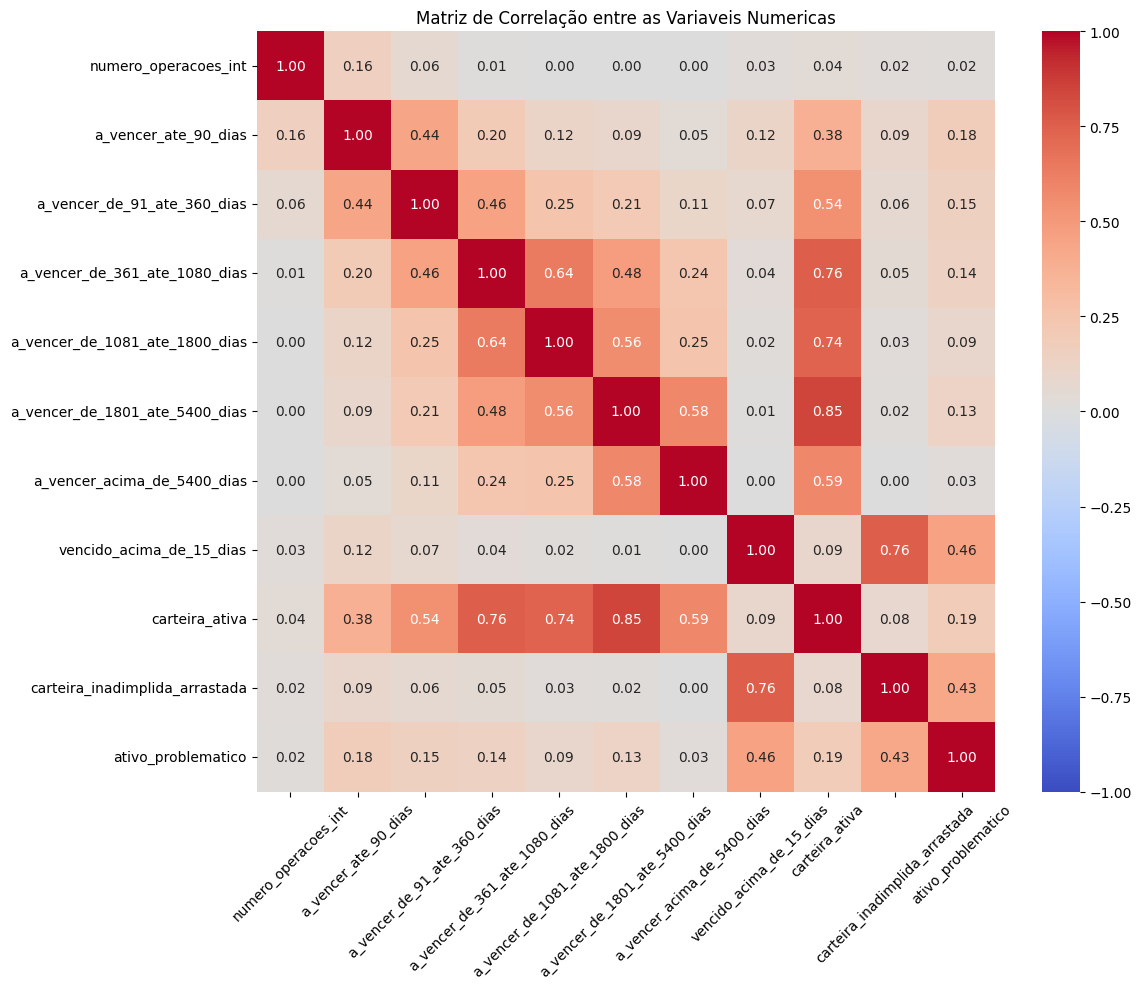

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

# Lista colunas numéricas
numeric_cols = [field.name for field in dados_copia_4.schema.fields
                if str(field.dataType) in ['IntegerType', 'LongType', 'FloatType', 'DoubleType', 'DecimalType']]

# Cria DataFrame apenas com colunas numéricas
df_numeric = dados_copia_4.select([col(c).cast("double") for c in numeric_cols])

# Converte as colunas numéricas em um vetor de características
assembler = VectorAssembler(inputCols=df_numeric.columns, outputCol="features")
df_vector = assembler.transform(df_numeric).select("features")

# Calcula a matriz de correlação
corr_matrix = Correlation.corr(df_vector, "features").collect()[0][0]

# Converte para array numpy
corr_array = corr_matrix.toArray()

# Cria heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_array,
            annot=True,
            fmt=".2f",
            xticklabels=numeric_cols,
            yticklabels=numeric_cols,
            cmap='coolwarm',
            vmin=-1,
            vmax=1)
plt.title("Matriz de Correlação entre as Variaveis Numericas")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

🔳 **Removendo colunas desnecessárias e as colunas fortemente correlacionadas entre si evitando multicolinearidade**

In [ ]:
# Lista de colunas a serem removidas (baseado na análise)
colunas_remover = [
    "a_vencer_de_1801_ate_5400_dias",
    "a_vencer_de_361_ate_1080_dias",
    "a_vencer_de_1081_ate_1800_dias",
    "carteira_inadimplida_arrastada",
    "numero_de_operacoes"
]

# Filtrar o DataFrame
dados_copia_5 = dados_copia_4.drop(*colunas_remover)
# Mostrar o resultado
dados_copia_5.show(12, truncate=False)

+----------+----------+---+----+---------+-------------+-------------------+------------------+---+--------+-------+-------------------------------------------------------------------+---------------------------------------------+---------------------------------------------+------------------------------------------------------------------------------+-------------------------+----------+--------------------+--------------------+---------------------------+---------------------------+------------------------+---------------+------------------+-----------+
|data_base |dia_do_ano|mes|ano |trimestre|eh_fim_de_ano|mes_sin            |mes_cos           |uf |tcb     |cliente|cnae_secao                                                         |cnae_subclasse                               |porte                                        |modalidade                                                                    |origem                   |indexador |numero_operacoes_int|a_vencer_ate_90_dias|a_v

## **2.3 Divisão entre atributos/previsores e classe**

🔳 **Visualizando nome das colunas e a quatidade colunas e linhas**

In [ ]:
# Ver colunas e tipos
dados_copia_5.printSchema()

# Contar linhas
print("Número de linhas:", dados_copia_5.count())
print("Número de colunas:", len(dados_copia_5.columns))

root
 |-- data_base: date (nullable = true)
 |-- dia_do_ano: integer (nullable = true)
 |-- mes: integer (nullable = true)
 |-- ano: integer (nullable = true)
 |-- trimestre: integer (nullable = true)
 |-- eh_fim_de_ano: integer (nullable = true)
 |-- mes_sin: double (nullable = true)
 |-- mes_cos: double (nullable = true)
 |-- uf: string (nullable = true)
 |-- tcb: string (nullable = true)
 |-- cliente: string (nullable = true)
 |-- cnae_secao: string (nullable = true)
 |-- cnae_subclasse: string (nullable = true)
 |-- porte: string (nullable = true)
 |-- modalidade: string (nullable = true)
 |-- origem: string (nullable = true)
 |-- indexador: string (nullable = true)
 |-- numero_operacoes_int: integer (nullable = true)
 |-- a_vencer_ate_90_dias: double (nullable = true)
 |-- a_vencer_de_91_ate_360_dias: double (nullable = true)
 |-- a_vencer_acima_de_5400_dias: double (nullable = true)
 |-- vencido_acima_de_15_dias: double (nullable = true)
 |-- carteira_ativa: double (nullable = tr

🔳  **Separando as variaveis independentes e dependente**

In [ ]:
from pyspark.sql.functions import col

# Definir features e target
features = [
    'dia_do_ano', 'mes', 'ano', 'trimestre', 'eh_fim_de_ano', 'mes_sin', 'mes_cos',
    'uf', 'tcb', 'cnae_secao', 'cnae_subclasse', 'porte', 'modalidade', 'origem',
    'indexador', 'numero_operacoes_int', 'a_vencer_ate_90_dias',
    'a_vencer_de_91_ate_360_dias', 'a_vencer_acima_de_5400_dias',
    'vencido_acima_de_15_dias', 'carteira_ativa', 'ativo_problematico'
]
target = "classe"

# Criar DataFrame apenas com colunas selecionadas
dados_modelo = dados_copia_5.select(features + [target])

# Verificar
print("Variáveis independentes:", features)
print("Variável dependente:", target)
dados_modelo.show(2)

Variáveis independentes: ['dia_do_ano', 'mes', 'ano', 'trimestre', 'eh_fim_de_ano', 'mes_sin', 'mes_cos', 'uf', 'tcb', 'cnae_secao', 'cnae_subclasse', 'porte', 'modalidade', 'origem', 'indexador', 'numero_operacoes_int', 'a_vencer_ate_90_dias', 'a_vencer_de_91_ate_360_dias', 'a_vencer_acima_de_5400_dias', 'vencido_acima_de_15_dias', 'carteira_ativa', 'ativo_problematico']
Variável dependente: classe
+----------+---+----+---------+-------------+-------------------+------------------+---+--------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+---------------------------+---------------------------+------------------------+---------------+------------------+-----------+
|dia_do_ano|mes| ano|trimestre|eh_fim_de_ano|            mes_sin|           mes_cos| uf|     tcb|          cnae_secao|      cnae_subclasse|               porte|          modalidade|              origem| indexador|

## **2.3 Tratamento dos atributos categóricos (LabelEncoder, OneHotEncoder)**

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Lista de colunas categóricas
categorical_cols = ['uf', 'tcb', 'cnae_secao', 'cnae_subclasse', 'porte', 'modalidade', 'origem', 'indexador']

# StringIndexer para cada coluna categórica
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep")
            for col in categorical_cols]

# OneHotEncoder
encoder = OneHotEncoder(
    inputCols=[f"{col}_index" for col in categorical_cols],
    outputCols=[f"{col}_encoded" for col in categorical_cols]
)

# Pipeline e execução
pipeline_categoricas = Pipeline(stages=indexers + [encoder])
dados_codificados = pipeline_categoricas.fit(dados_modelo).transform(dados_modelo)

# Verificar
dados_codificados.select([f"{col}_encoded" for col in categorical_cols]).show(2)

+---------------+-------------+------------------+----------------------+-------------+------------------+--------------+-----------------+
|     uf_encoded|  tcb_encoded|cnae_secao_encoded|cnae_subclasse_encoded|porte_encoded|modalidade_encoded|origem_encoded|indexador_encoded|
+---------------+-------------+------------------+----------------------+-------------+------------------+--------------+-----------------+
|(27,[24],[1.0])|(3,[0],[1.0])|   (21,[18],[1.0])|    (1263,[646],[1.0])|(4,[3],[1.0])|     (9,[4],[1.0])| (2,[1],[1.0])|    (6,[1],[1.0])|
|(27,[14],[1.0])|(3,[0],[1.0])|    (21,[0],[1.0])|     (1263,[43],[1.0])|(4,[0],[1.0])|     (9,[1],[1.0])| (2,[0],[1.0])|    (6,[0],[1.0])|
+---------------+-------------+------------------+----------------------+-------------+------------------+--------------+-----------------+
only showing top 2 rows



## **2.4 Escalonamento dos Valores Numéricos**

In [ ]:
from pyspark.ml.feature import StandardScaler, VectorAssembler

# Colunas numéricas para escalonar
numeric_cols = [
    'dia_do_ano', 'mes', 'ano', 'trimestre', 'eh_fim_de_ano', 'mes_sin', 'mes_cos',
    'numero_operacoes_int', 'a_vencer_ate_90_dias', 'a_vencer_de_91_ate_360_dias',
    'a_vencer_acima_de_5400_dias', 'vencido_acima_de_15_dias', 'carteira_ativa', 'ativo_problematico'
]

# Vetorização + Escalonamento
numeric_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")
scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features")

# Aplicar transformações
dados_numeric = numeric_assembler.transform(dados_codificados)
dados_scaled = scaler.fit(dados_numeric).transform(dados_numeric)

# Verificar
dados_scaled.select("numeric_features", "scaled_numeric_features").show(2, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|numeric_features                                                                                                                   |scaled_numeric_features                                                                                                                                                                                                      |
+-----------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------

## **2.5 Preparação Final dos Dados**

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Combinar features categóricas (já codificadas) e numéricas (já escalonadas)
final_assembler = VectorAssembler(
    inputCols=[f"{col}_encoded" for col in categorical_cols] + ["scaled_numeric_features"],
    outputCol="features"
)

# Aplicar
dados_finais = final_assembler.transform(dados_scaled)

# Verificar esquema
dados_finais.printSchema()
dados_finais.select("features", "classe").show(2, truncate=False)

root
 |-- dia_do_ano: integer (nullable = true)
 |-- mes: integer (nullable = true)
 |-- ano: integer (nullable = true)
 |-- trimestre: integer (nullable = true)
 |-- eh_fim_de_ano: integer (nullable = true)
 |-- mes_sin: double (nullable = true)
 |-- mes_cos: double (nullable = true)
 |-- uf: string (nullable = true)
 |-- tcb: string (nullable = true)
 |-- cnae_secao: string (nullable = true)
 |-- cnae_subclasse: string (nullable = true)
 |-- porte: string (nullable = true)
 |-- modalidade: string (nullable = true)
 |-- origem: string (nullable = true)
 |-- indexador: string (nullable = true)
 |-- numero_operacoes_int: integer (nullable = true)
 |-- a_vencer_ate_90_dias: double (nullable = true)
 |-- a_vencer_de_91_ate_360_dias: double (nullable = true)
 |-- a_vencer_acima_de_5400_dias: double (nullable = true)
 |-- vencido_acima_de_15_dias: double (nullable = true)
 |-- carteira_ativa: double (nullable = true)
 |-- ativo_problematico: double (nullable = true)
 |-- classe: string (nul

## **2.6 Divisão da base em treinamento e teste**

In [ ]:
# Divisão 80% treino, 20% teste
train, test = dados_finais.randomSplit([0.8, 0.2], seed=42)

# Contagem de linhas
print(f"Treino: {train.count()} linhas")
print(f"Teste: {test.count()} linhas")

# Ver proporção das classes
print("\nDistribuição no treino:")
train.groupBy("classe").count().show()

print("\nDistribuição no teste:")
test.groupBy("classe").count().show()

Treino: 67864112 linhas
Teste: 16972150 linhas

Distribuição no treino:
+-----------+--------+
|     classe|   count|
+-----------+--------+
| Alto Risco|16644406|
|Médio Risco| 2760919|
|Baixo Risco|48458787|
+-----------+--------+


Distribuição no teste:
+-----------+--------+
|     classe|   count|
+-----------+--------+
| Alto Risco| 4163016|
|Médio Risco|  692179|
|Baixo Risco|12116955|
+-----------+--------+



## **2.7 Salvando os dados processados**

In [ ]:
# Definir o caminho base
base_path = "/content/drive/My Drive/BCB_Dados_Corrigidos_2024/"

# Salvar os dados de treino e teste
train.write.mode("overwrite").parquet(base_path + "dados_treino.parquet")
test.write.mode("overwrite").parquet(base_path + "dados_teste.parquet")

# **3. Modelagem**

## **3.1 Carregando e visualizando os dados processados**

🔳 **Iniciando o spark**

In [ ]:
# 1️⃣ Instalar Java 8 (necessário para o Spark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# 2️⃣ Baixar e configurar o Spark
# Baixar o Spark 3.2.1 com Hadoop 2.7
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

# Extrair o arquivo baixado
!tar xf spark-3.2.1-bin-hadoop2.7.tgz

# Configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

# 3️⃣ Instalar o findspark e inicializar o Spark
!pip install -q findspark
import findspark
findspark.init()

# 4️⃣ Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 5️⃣ Criar uma sessão Spark
from pyspark.sql import SparkSession

# Criar a sessão Spark
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("ParquetProcessing") \
    .getOrCreate()

Mounted at /content/drive


🔳 **Carregando os dados processados**

In [ ]:
from pyspark.sql.types import *
from pyspark.ml.linalg import VectorUDT  # Importação necessária para VectorUDT

# Definir caminhos
base_path = "/content/drive/My Drive/BCB_Dados_Corrigidos_2024/"
train_path = base_path + "dados_treino.parquet"
test_path = base_path + "dados_teste.parquet"

# Verificar se arquivos existem
if not os.path.exists(train_path):
    raise FileNotFoundError(f"Arquivo {train_path} não encontrado!")
if not os.path.exists(test_path):
    raise FileNotFoundError(f"Arquivo {test_path} não encontrado!")

# Definir schema manual
custom_schema = StructType([
    StructField("dia_do_ano", IntegerType(), True),
    StructField("mes", IntegerType(), True),
    StructField("ano", IntegerType(), True),
    StructField("trimestre", IntegerType(), True),
    StructField("eh_fim_de_ano", IntegerType(), True),
    StructField("mes_sin", DoubleType(), True),
    StructField("mes_cos", DoubleType(), True),
    StructField("uf", StringType(), True),
    StructField("tcb", StringType(), True),
    StructField("cnae_secao", StringType(), True),
    StructField("cnae_subclasse", StringType(), True),
    StructField("porte", StringType(), True),
    StructField("modalidade", StringType(), True),
    StructField("origem", StringType(), True),
    StructField("indexador", StringType(), True),
    StructField("numero_operacoes_int", IntegerType(), True),
    StructField("a_vencer_ate_90_dias", DoubleType(), True),
    StructField("a_vencer_de_91_ate_360_dias", DoubleType(), True),
    StructField("a_vencer_acima_de_5400_dias", DoubleType(), True),
    StructField("vencido_acima_de_15_dias", DoubleType(), True),
    StructField("carteira_ativa", DoubleType(), True),
    StructField("ativo_problematico", DoubleType(), True),
    StructField("classe", StringType(), False),
    StructField("features", VectorUDT(), True)  # Agora VectorUDT está definido
])

# Carregar dados com schema manual
try:
    train = spark.read.schema(custom_schema).parquet(train_path)
    test = spark.read.schema(custom_schema).parquet(test_path)

    print("Dados carregados com sucesso!")
    print("\nEsquema do treino:")
    train.printSchema()

except Exception as e:
    print(f"Erro ao carregar dados: {str(e)}")

Dados carregados com sucesso!

Esquema do treino:
root
 |-- dia_do_ano: integer (nullable = true)
 |-- mes: integer (nullable = true)
 |-- ano: integer (nullable = true)
 |-- trimestre: integer (nullable = true)
 |-- eh_fim_de_ano: integer (nullable = true)
 |-- mes_sin: double (nullable = true)
 |-- mes_cos: double (nullable = true)
 |-- uf: string (nullable = true)
 |-- tcb: string (nullable = true)
 |-- cnae_secao: string (nullable = true)
 |-- cnae_subclasse: string (nullable = true)
 |-- porte: string (nullable = true)
 |-- modalidade: string (nullable = true)
 |-- origem: string (nullable = true)
 |-- indexador: string (nullable = true)
 |-- numero_operacoes_int: integer (nullable = true)
 |-- a_vencer_ate_90_dias: double (nullable = true)
 |-- a_vencer_de_91_ate_360_dias: double (nullable = true)
 |-- a_vencer_acima_de_5400_dias: double (nullable = true)
 |-- vencido_acima_de_15_dias: double (nullable = true)
 |-- carteira_ativa: double (nullable = true)
 |-- ativo_problematico:

🔳 **Visualizando os dados treino**

In [ ]:
train.show(10, truncate=False)
print("Número de linhas:", train.count())

+----------+---+----+---------+-------------+-------------------+-------------------+---+--------+-------------------------------------------------------------------+---------------------------------------------+---------------------------------------------+------------------------------------------------------------------------------+-------------------------+-----------------+--------------------+--------------------+---------------------------+---------------------------+------------------------+--------------+------------------+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|dia_do_ano|mes|ano |trimestre|eh_fim_de_ano|mes_sin            |mes_cos            |uf 

🔳 **Ajustando a classe nos dados de treino**

In [ ]:
from pyspark.ml.feature import StringIndexer

# Criar um indexador para a coluna "classe"
indexer = StringIndexer(inputCol="classe", outputCol="label")
train_1 = indexer.fit(train).transform(train)

# Verificar o resultado
train_1.select("classe", "label").show(5)

+-----------+-----+
|     classe|label|
+-----------+-----+
| Alto Risco|  1.0|
|Baixo Risco|  0.0|
|Baixo Risco|  0.0|
|Baixo Risco|  0.0|
|Baixo Risco|  0.0|
+-----------+-----+
only showing top 5 rows



In [ ]:
# Visualizando a base completa
train_1.show(10)

+----------+---+----+---------+-------------+-------------------+-------------------+---+--------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+---------------------------+---------------------------+------------------------+--------------+------------------+-----------+--------------------+-----+
|dia_do_ano|mes| ano|trimestre|eh_fim_de_ano|            mes_sin|            mes_cos| uf|     tcb|          cnae_secao|      cnae_subclasse|               porte|          modalidade|              origem|        indexador|numero_operacoes_int|a_vencer_ate_90_dias|a_vencer_de_91_ate_360_dias|a_vencer_acima_de_5400_dias|vencido_acima_de_15_dias|carteira_ativa|ativo_problematico|     classe|            features|label|
+----------+---+----+---------+-------------+-------------------+-------------------+---+--------+--------------------+--------------------+--------------------+---

In [ ]:
# Mostrar o esquema para ver as colunas disponíveis
train_1.printSchema()

# Verificar as colunas que compõem o vetor 'features'
train_1.select("features").show(1, truncate=False)

root
 |-- dia_do_ano: integer (nullable = true)
 |-- mes: integer (nullable = true)
 |-- ano: integer (nullable = true)
 |-- trimestre: integer (nullable = true)
 |-- eh_fim_de_ano: integer (nullable = true)
 |-- mes_sin: double (nullable = true)
 |-- mes_cos: double (nullable = true)
 |-- uf: string (nullable = true)
 |-- tcb: string (nullable = true)
 |-- cnae_secao: string (nullable = true)
 |-- cnae_subclasse: string (nullable = true)
 |-- porte: string (nullable = true)
 |-- modalidade: string (nullable = true)
 |-- origem: string (nullable = true)
 |-- indexador: string (nullable = true)
 |-- numero_operacoes_int: integer (nullable = true)
 |-- a_vencer_ate_90_dias: double (nullable = true)
 |-- a_vencer_de_91_ate_360_dias: double (nullable = true)
 |-- a_vencer_acima_de_5400_dias: double (nullable = true)
 |-- vencido_acima_de_15_dias: double (nullable = true)
 |-- carteira_ativa: double (nullable = true)
 |-- ativo_problematico: double (nullable = true)
 |-- classe: string (nul

🔳 **Visualizando os dados teste (Amostra de teste)**

In [ ]:
from pyspark.sql.functions import col

# Filtrar 7 registros de cada classe (já indexados)
amostra_baixo = train_1.filter(col("classe") == "Baixo Risco").limit(2760919)
amostra_medio = train_1.filter(col("classe") == "Médio Risco").limit(2760919)
amostra_alto = train_1.filter(col("classe") == "Alto Risco").limit(2760919)

# Unir as amostras
test_sample = amostra_baixo.union(amostra_medio).union(amostra_alto)

# Verificar (opcional)
test_sample.show(7)

+----------+---+----+---------+-------------+-------------------+-------------------+---+--------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+---------------------------+---------------------------+------------------------+--------------+------------------+-----------+--------------------+-----+
|dia_do_ano|mes| ano|trimestre|eh_fim_de_ano|            mes_sin|            mes_cos| uf|     tcb|          cnae_secao|      cnae_subclasse|               porte|          modalidade|              origem|        indexador|numero_operacoes_int|a_vencer_ate_90_dias|a_vencer_de_91_ate_360_dias|a_vencer_acima_de_5400_dias|vencido_acima_de_15_dias|carteira_ativa|ativo_problematico|     classe|            features|label|
+----------+---+----+---------+-------------+-------------------+-------------------+---+--------+--------------------+--------------------+--------------------+---

🔳 **Quantidade de linhas total e por classe e label dos dados teste (Amostra de teste)**

In [ ]:
# Contagem de linhas
print(f"Teste: {test_sample.count()} linhas")

# Ver proporção das classes
print("\nDistribuição no teste:")
test_sample.groupBy("classe", "label").count().show()

Teste: 13760919 linhas

Distribuição no teste:
+-----------+-----+-------+
|     classe|label|  count|
+-----------+-----+-------+
|Baixo Risco|  0.0|5500000|
|Médio Risco|  2.0|2760919|
| Alto Risco|  1.0|5500000|
+-----------+-----+-------+



## **3.2 Treinando os modelos**

**--------------------------------------------------------------------------**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import when

# 1. Definir a base de treino
train_1 = train_1  # Já está carregada

# 2. Usar contagens definidas manualmente para cada classe
class_counts = {
    0.0: 48458787,  # Baixo Risco
    1.0: 16644406,  # Alto Risco
    2.0: 2760919    # Médio Risco
}

total = sum(class_counts.values())

# 3. Calcular os pesos ajustados conforme proporção especificada
weights = {
    0.0: total / (class_counts[0.0] * 0.3),  # Reduz peso da maioria
    1.0: total / (class_counts[1.0] * 3),    # Peso extra para Alto Risco
    2.0: total / class_counts[2.0]           # Peso padrão para Médio Risco
}

# 4. Adicionar coluna de pesos ao DataFrame
train_1_weight = train_1.withColumn(
    "weight",
    when(train_1.label == 0.0, weights[0.0])
    .when(train_1.label == 1.0, weights[1.0])
    .otherwise(weights[2.0])
)

# 5. Verificar a distribuição dos pesos
train_1_weight.groupBy("label", "weight").count().show()

# 6. Criar e treinar o modelo RandomForest com pesos ajustados
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=100,
    maxDepth=10,
    minInstancesPerNode=5,
    weightCol="weight",
    seed=42
)

modelo_rf_ajustado = rf.fit(train_1_weight)

# 7. Salvar o modelo treinado
model_path = "/content/drive/My Drive/BCB_Dados_Corrigidos_2024/modelo_rf_ajustado"
modelo_rf_ajustado.write().overwrite().save(model_path)
print(f"Modelo salvo em: {model_path}")

**----------------------------------------------------------------------------**

🔳 **Criando o algoritmo do modelo RandomForest, passando os dados de treino e salvando para posteriormente somente carregar**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import when

# 1. Calcular os pesos para cada classe (inverso da proporção)
count_by_class = train_indexed.groupBy("label").count().collect()

# Extrair contagens corretamente (usando ['count'] em vez de .count)
class_counts = {row['label']: row['count'] for row in count_by_class}
total = sum(class_counts.values())

weight_0 = total / class_counts[0.0]  # Baixo Risco
weight_1 = total / class_counts[1.0]  # Médio Risco
weight_2 = total / class_counts[2.0]  # Alto Risco

# 2. Adicionar coluna de pesos ao DataFrame
train_with_weights = train_indexed.withColumn(
    "weight",
    when(train_indexed.label == 0.0, weight_0)
    .when(train_indexed.label == 1.0, weight_1)
    .otherwise(weight_2)
)

# 3. Verificar a distribuição dos pesos
train_with_weights.groupBy("label", "weight").count().show()

# 4. Criar e treinar o modelo RandomForest
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=15,
    maxDepth=5,
    minInstancesPerNode=10,
    weightCol="weight",
    seed=42
)

modelo_rf = rf.fit(train_with_weights)

In [ ]:

# 5. Salvar o modelo
model_path = "/content/drive/My Drive/BCB_Dados_Corrigidos_2024/modelo_rf"
modelo_rf.write().overwrite().save(model_path)
print(f"Modelo salvo em: {model_path}")

In [ ]:
### Verificando se os dados foram salvos corretamente

# Carregando bibliotecas
from pyspark.ml.classification import RandomForestClassificationModel
import os

# Caminho onde o modelo foi salvo
model_path = "/content/drive/My Drive/BCB_Dados_Corrigidos_2024/modelo_rf"

# Verificar se os arquivos do modelo existem
print("Conteúdo do diretório do modelo:")
print(os.listdir(model_path))

# Tentar carregar o modelo
try:
    modelo_test = RandomForestClassificationModel.load(model_path)
    print("\n✅ Modelo carregado com sucesso!")
    print("Árvores no modelo:", modelo_test.getNumTrees)
except Exception as e:
    print("\n❌ Erro ao carregar:", str(e))

Conteúdo do diretório do modelo:
['metadata', 'treesMetadata', 'data']

✅ Modelo carregado com sucesso!
Árvores no modelo: 100


🔳 **Fazendo as previsões com os dados de amostra para teste**

In [ ]:
# Carregar o modelo
modelo_rf = RandomForestClassificationModel.load(model_path)

# Fazer previsões na amostra
predicoes = modelo_rf.transform(test_sample)

# Mostrar resultados
print("\n🔎 Resultados:")
predicoes.select("classe", "label", "prediction", "probability").show(21, truncate=False)


🔎 Resultados:
+-----------+-----+----------+-------------------------------------------------------------+
|classe     |label|prediction|probability                                                  |
+-----------+-----+----------+-------------------------------------------------------------+
|Baixo Risco|0.0  |0.0       |[0.49869825646609506,0.2228024759520535,0.2784992675818515]  |
|Baixo Risco|0.0  |0.0       |[0.4274401988965675,0.2514359713397095,0.321123829763723]    |
|Baixo Risco|0.0  |0.0       |[0.3768706328194188,0.27119124615949974,0.3519381210210814]  |
|Baixo Risco|0.0  |0.0       |[0.46078692955689954,0.23801161191219639,0.30120145853090413]|
|Baixo Risco|0.0  |0.0       |[0.46428429732097803,0.24852015443698627,0.28719554824203575]|
|Baixo Risco|0.0  |0.0       |[0.44163191355260945,0.24625717487314894,0.3121109115742416] |
|Baixo Risco|0.0  |0.0       |[0.42705896574347885,0.2430381789556544,0.32990285530086677] |
|Baixo Risco|0.0  |0.0       |[0.4510037544860897,0.235

🔳 **Avaliação do modelo com a matrix de confusão**

In [ ]:
from pyspark.sql.functions import col

# Gerar matriz de confusão
confusion_matrix = predicoes.groupBy("label", "prediction").count().orderBy("label", "prediction")

# Mostrar de forma mais legível (pivot)
confusion_matrix_pivot = confusion_matrix.groupBy("label")\
    .pivot("prediction", [0.0, 1.0, 2.0])\
    .sum("count")\
    .orderBy("label")

print("=== MATRIZ DE CONFUSÃO ===")
print("Linhas: Real | Colunas: Previsto")
confusion_matrix_pivot.show()

# Opcional: Versão visual com Pandas
confusion_matrix_pd = confusion_matrix_pivot.toPandas()
confusion_matrix_pd.set_index("label", inplace=True)
print("\nMatriz de Confusão (Formato Numérico):")
print(confusion_matrix_pd)

=== MATRIZ DE CONFUSÃO ===
Linhas: Real | Colunas: Previsto
+-----+-------+-------+-------+
|label|    0.0|    1.0|    2.0|
+-----+-------+-------+-------+
|  0.0|2332816| 345927|  82176|
|  1.0|  80556|2667589|  12774|
|  2.0| 423223|1026306|1311390|
+-----+-------+-------+-------+


Matriz de Confusão (Formato Numérico):
           0.0      1.0      2.0
label                           
0.0    2332816   345927    82176
1.0      80556  2667589    12774
2.0     423223  1026306  1311390


🔳 **Relatório de classificação (mostra métricas adicionais como precision, recall, f1-score, suporte)**

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

try:
    # 1. Verificar colunas disponíveis
    print("Colunas disponíveis no DataFrame:")
    print(predicoes.columns)

    # 2. Definir nomes das colunas (ajuste conforme seu DataFrame)
    label_col = "label"          # Coluna com as classes reais
    prediction_col = "prediction" # Coluna com as predições

    # 3. Converter para Pandas
    pdf = predicoes.select(label_col, prediction_col).toPandas()

    # 4. Verificar conversão
    print("\nPrimeiras linhas dos dados:")
    print(pdf.head())

    # 5. Gerar métricas
    report = classification_report(
        pdf[label_col],
        pdf[prediction_col],
        target_names=['Baixo Risco', 'Médio Risco', 'Alto Risco'],  # Ajuste os nomes
        output_dict=True
    )

    # 6. Exibir resultados
    metrics_df = pd.DataFrame(report).transpose()
    print("\n📊 Métricas Detalhadas:")
    display(metrics_df)

except Exception as e:
    print(f"\n❌ Erro: {str(e)}")
    print("Possíveis causas:")
    print("- Nomes das colunas incorretos")
    print("- Dados não convertidos corretamente")
    print("- Valores nulos nas colunas")

Colunas disponíveis no DataFrame:
['dia_do_ano', 'mes', 'ano', 'trimestre', 'eh_fim_de_ano', 'mes_sin', 'mes_cos', 'uf', 'tcb', 'cnae_secao', 'cnae_subclasse', 'porte', 'modalidade', 'origem', 'indexador', 'numero_operacoes_int', 'a_vencer_ate_90_dias', 'a_vencer_de_91_ate_360_dias', 'a_vencer_acima_de_5400_dias', 'vencido_acima_de_15_dias', 'carteira_ativa', 'ativo_problematico', 'classe', 'features', 'label', 'rawPrediction', 'probability', 'prediction']

Primeiras linhas dos dados:
   label  prediction
0    0.0         0.0
1    0.0         0.0
2    0.0         0.0
3    0.0         0.0
4    0.0         0.0

📊 Métricas Detalhadas:


,precision,recall,f1-score,support
Baixo Risco,0.822400,0.844942,0.833519,2.760919e+06
Médio Risco,0.660323,0.966196,0.784500,2.760919e+06
Alto Risco,0.932484,0.474983,0.629378,2.760919e+06
accuracy,0.762040,0.762040,0.762040,7.620403e-01
macro avg,0.805069,0.762040,0.749132,8.282757e+06
weighted avg,0.805069,0.762040,0.749132,8.282757e+06


**------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **RASCUNHO**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import col, when

# 1. Calcular pesos customizados
class_counts = {
    0.0: 48458787,  # Baixo Risco
    1.0: 16644406,  # Alto Risco
    2.0: 2760919    # Médio Risco
}

total = sum(class_counts.values())
weights = {
    0.0: total / (class_counts[0.0] * 0.3),  # Reduz peso da maioria
    1.0: total / (class_counts[1.0] * 3),    # Peso extra para Alto Risco
    2.0: total / class_counts[2.0]           # Peso padrão para Médio Risco
}

# 2. Aplicar pesos
train_with_weights = train_1.withColumn(
    "weight",
    when(col("label") == 0.0, weights[0.0])
    .when(col("label") == 1.0, weights[1.0])
    .otherwise(weights[2.0])
)

# 3. Configurar e treinar o modelo
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    weightCol="weight",
    numTrees=100,
    maxDepth=10,
    minInstancesPerNode=5,
    maxBins=32,
    impurity="gini",
    seed=42
)

# 4. Treinar o modelo
modelo_rf = rf.fit(train_with_weights)

# 5. Salvar o modelo
model_path = "/content/drive/My Drive/BCB_Dados_Corrigidos_2024/modelo_rf_otimizado"
modelo_rf.write().overwrite().save(model_path)
print(f"Modelo salvo em: {model_path}")

#**PIPELINE COMPLETO PARA CRIAÇÃO DA APLICAÇÃO**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
)

# ✅ CAMINHO onde o pipeline será salvo no Google Drive:
pipeline_path = "/content/drive/MyDrive/pipeline_model"

# 🔶 Definir as colunas usadas no seu modelo
categorical_cols = ['uf', 'tcb', 'cnae_secao', 'cnae_subclasse', 'porte', 'modalidade', 'origem', 'indexador']
numeric_cols = [
    'dia_do_ano', 'mes', 'ano', 'trimestre', 'eh_fim_de_ano', 'mes_sin', 'mes_cos',
    'numero_operacoes_int', 'a_vencer_ate_90_dias', 'a_vencer_de_91_ate_360_dias',
    'a_vencer_acima_de_5400_dias', 'vencido_acima_de_15_dias', 'carteira_ativa', 'ativo_problematico'
]

# 🔶 Criação do pipeline
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep") for col in categorical_cols]

encoder = OneHotEncoder(
    inputCols=[f"{col}_index" for col in categorical_cols],
    outputCols=[f"{col}_encoded" for col in categorical_cols]
)

numeric_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")
scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features")

final_assembler = VectorAssembler(
    inputCols=[f"{col}_encoded" for col in categorical_cols] + ["scaled_numeric_features"],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + [encoder, numeric_assembler, scaler, final_assembler])

# 🟡 Ajuste com seus dados (ex: train_1)
pipeline_model = pipeline.fit(train_1)

# 💾 Salvar no Google Drive
pipeline_model.write().overwrite().save(pipeline_path)
print(f"✅ Pipeline salvo com sucesso em: {pipeline_path}")

# Salvando os dados em pandas para rodar a aplicação Streamlit

In [ ]:
from pyspark.sql.functions import col

# Filtrar 1.666.666 registros de cada classe (após indexação com StringIndexer)
train_baixo = train_1.filter(col("label") == 0.0).limit(1666666)
train_medio = train_1.filter(col("label") == 2.0).limit(1666666)
train_alto  = train_1.filter(col("label") == 1.0).limit(1666666)

# Combinar os três conjuntos
train_streamlit = train_baixo.union(train_medio).union(train_alto)

# Salvar como CSV no Drive
output_path = "/content/drive/My Drive/BCB_Dados_Corrigidos_2024/train_streamlit.csv"

# Salvar em CSV
train_streamlit.toPandas().to_csv(output_path, index=False)
print(f"Arquivo salvo com sucesso em: {output_path}")

Py4JJavaError: An error occurred while calling o111.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 17.0 failed 1 times, most recent failure: Lost task 0.0 in stage 17.0 (TID 530) (2968ff0de2d6 executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:223)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:176)
	at java.io.DataOutputStream.write(DataOutputStream.java:107)
	at org.apache.spark.sql.catalyst.expressions.UnsafeRow.writeToStream(UnsafeRow.java:541)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:352)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$2395/447626157.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.RDD$$Lambda$2396/1121605804.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2355/1256239535.apply(Unknown Source)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:394)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:338)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:366)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:338)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3538)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3706)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3704)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3535)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:223)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:176)
	at java.io.DataOutputStream.write(DataOutputStream.java:107)
	at org.apache.spark.sql.catalyst.expressions.UnsafeRow.writeToStream(UnsafeRow.java:541)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:352)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$2395/447626157.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.RDD$$Lambda$2396/1121605804.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2355/1256239535.apply(Unknown Source)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
